In [37]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import fisherz
from causallearn.graph.GraphNode import GraphNode
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
import networkx as nx
import matplotlib.pyplot as plt

In [39]:
def load_dataset(filename):
    try:
        return np.loadtxt(filename)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return np.array([])

def load_all_datasets(base_path):
    datasets = {}
    for i in range(22):
        train_file = os.path.join(base_path, f'd{i:02d}.dat')
        test_file = os.path.join(base_path, f'd{i:02d}_te.dat')
        
        if os.path.exists(train_file) and os.path.exists(test_file):
            train_data = load_dataset(train_file)
            test_data = load_dataset(test_file)
            if train_data.size == 0 or test_data.size == 0:
                continue
            combined_data = np.vstack((train_data, test_data))
            datasets[f'fault_{i:02d}'] = combined_data
    
    return datasets

def standardize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [41]:
def run_fci(data, alpha=0.05):
    try:
        G, edges = fci(data, fisherz, alpha)
        return G, edges
    except Exception as e:
        print(f"Error running FCI: {e}")
        return None, None

def print_causal_relationships(G):
    if G is None:
        print("No graph available to analyze.")
        return

    print("\nCausal Relationships:")
    for edge in G.get_graph_edges():
        node1, node2 = edge.get_node1(), edge.get_node2()
        relationship = ""
        if edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.ARROW:
            relationship = "Bidirectional Causal"
        elif edge.get_endpoint1() == Endpoint.ARROW:
            relationship = f"{node2.get_name()} causes {node1.get_name()}"
        elif edge.get_endpoint2() == Endpoint.ARROW:
            relationship = f"{node1.get_name()} causes {node2.get_name()}"
        elif edge.get_endpoint1() == Endpoint.CIRCLE or edge.get_endpoint2() == Endpoint.CIRCLE:
            relationship = "Potential Causal (Uncertain Direction)"
        else:
            relationship = "Undirected Association"
        
        print(f"{node1.get_name()} -- {node2.get_name()}: {relationship}")

def summarize_graph(G):
    if G is None:
        print("No graph available to summarize.")
        return

    num_nodes = len(G.get_nodes())
    num_edges = len(G.get_graph_edges())
    
    causal_count = 0
    bidirectional_count = 0
    uncertain_count = 0
    undirected_count = 0
    
    for edge in G.get_graph_edges():
        if edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.ARROW:
            bidirectional_count += 1
        elif edge.get_endpoint1() == Endpoint.ARROW or edge.get_endpoint2() == Endpoint.ARROW:
            causal_count += 1
        elif edge.get_endpoint1() == Endpoint.CIRCLE or edge.get_endpoint2() == Endpoint.CIRCLE:
            uncertain_count += 1
        else:
            undirected_count += 1
    
    print("\nGraph Summary:")
    print(f"Number of variables (nodes): {num_nodes}")
    print(f"Number of relationships (edges): {num_edges}")
    print(f"Causal relationships: {causal_count}")
    print(f"Bidirectional causal relationships: {bidirectional_count}")
    print(f"Uncertain causal relationships: {uncertain_count}")
    print(f"Undirected associations: {undirected_count}")

In [43]:
def visualize_graph(G, title="DAG Visualization", show_weights=False, causal_only=False, hide_unconnected=False):
    if G is None:
        print("No graph available to visualize.")
        return

    nx_graph = nx.DiGraph()

    for node in G.get_nodes():
        nx_graph.add_node(node.get_name())

    edge_colors = []
    
    for edge in G.get_graph_edges():
        node1 = edge.get_node1().get_name()
        node2 = edge.get_node2().get_name()
        
        if edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.ARROW:
            color = 'purple'  # Bidirectional causal
            if causal_only:
                continue  # Skip bidirectional if only causal relationships are required
        elif edge.get_endpoint1() == Endpoint.ARROW:
            color = 'green'  # node2 causes node1
            if causal_only and edge.get_endpoint2() != Endpoint.ARROW:
                nx_graph.add_edge(node2, node1)  # Add causal edge
            elif causal_only:
                continue
        elif edge.get_endpoint2() == Endpoint.ARROW:
            color = 'green'  # node1 causes node2
            if causal_only and edge.get_endpoint1() != Endpoint.ARROW:
                nx_graph.add_edge(node1, node2)  # Add causal edge
            elif causal_only:
                continue
        elif edge.get_endpoint1() == Endpoint.CIRCLE or edge.get_endpoint2() == Endpoint.CIRCLE:
            color = 'orange'  # Uncertain causal
            if causal_only:
                continue  # Skip uncertain if only causal relationships are required
        else:
            color = 'blue'  # Undirected association
            if causal_only:
                continue  # Skip undirected if only causal relationships are required
        
        if not causal_only:
            nx_graph.add_edge(node1, node2)
        edge_colors.append(color)

    if hide_unconnected:
        isolated_nodes = [node for node in nx_graph.nodes() if nx_graph.degree(node) == 0]
        nx_graph.remove_nodes_from(isolated_nodes)

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(nx_graph, k=0.5, seed=42)  

    nx.draw(
        nx_graph, pos, edge_color=edge_colors, node_size=3000, 
        node_color='lightblue', with_labels=True, font_weight='bold',
        font_size=10, connectionstyle='arc3,rad=0.1', alpha=0.9
    )

    plt.title(title)
    plt.show()

Running FCI for combined variable data...


  0%|          | 0/52 [00:00<?, ?it/s]

X3 --> X41
X8 --> X6
X20 --> X6
X7 --> X13
X8 --> X45
X35 --> X10
X39 --> X10
X11 --> X35
X16 --> X52
X18 --> X19
X29 --> X23
X23 --> X31
X30 --> X24
X24 --> X32
X42 --> X26
X27 --> X33
X38 --> X33
X47 --> X35
X45 --> X42
X42 --> X52

FCI analysis completed.

Causal Relationships:
X1 -- X4: Bidirectional Causal
X1 -- X44: Bidirectional Causal
X2 -- X3: Bidirectional Causal
X2 -- X6: Bidirectional Causal
X2 -- X21: Bidirectional Causal
X2 -- X27: Bidirectional Causal
X2 -- X32: Bidirectional Causal
X2 -- X37: Bidirectional Causal
X3 -- X40: Bidirectional Causal
X3 -- X41: X3 causes X41
X4 -- X6: Bidirectional Causal
X4 -- X8: Bidirectional Causal
X4 -- X21: Bidirectional Causal
X4 -- X26: Bidirectional Causal
X4 -- X45: Bidirectional Causal
X5 -- X14: Bidirectional Causal
X5 -- X46: Bidirectional Causal
X8 -- X6: X8 causes X6
X20 -- X6: X20 causes X6
X6 -- X21: Bidirectional Causal
X6 -- X26: Bidirectional Causal
X6 -- X43: Bidirectional Causal
X7 -- X11: Bidirectional Causal
X7 -- X13:

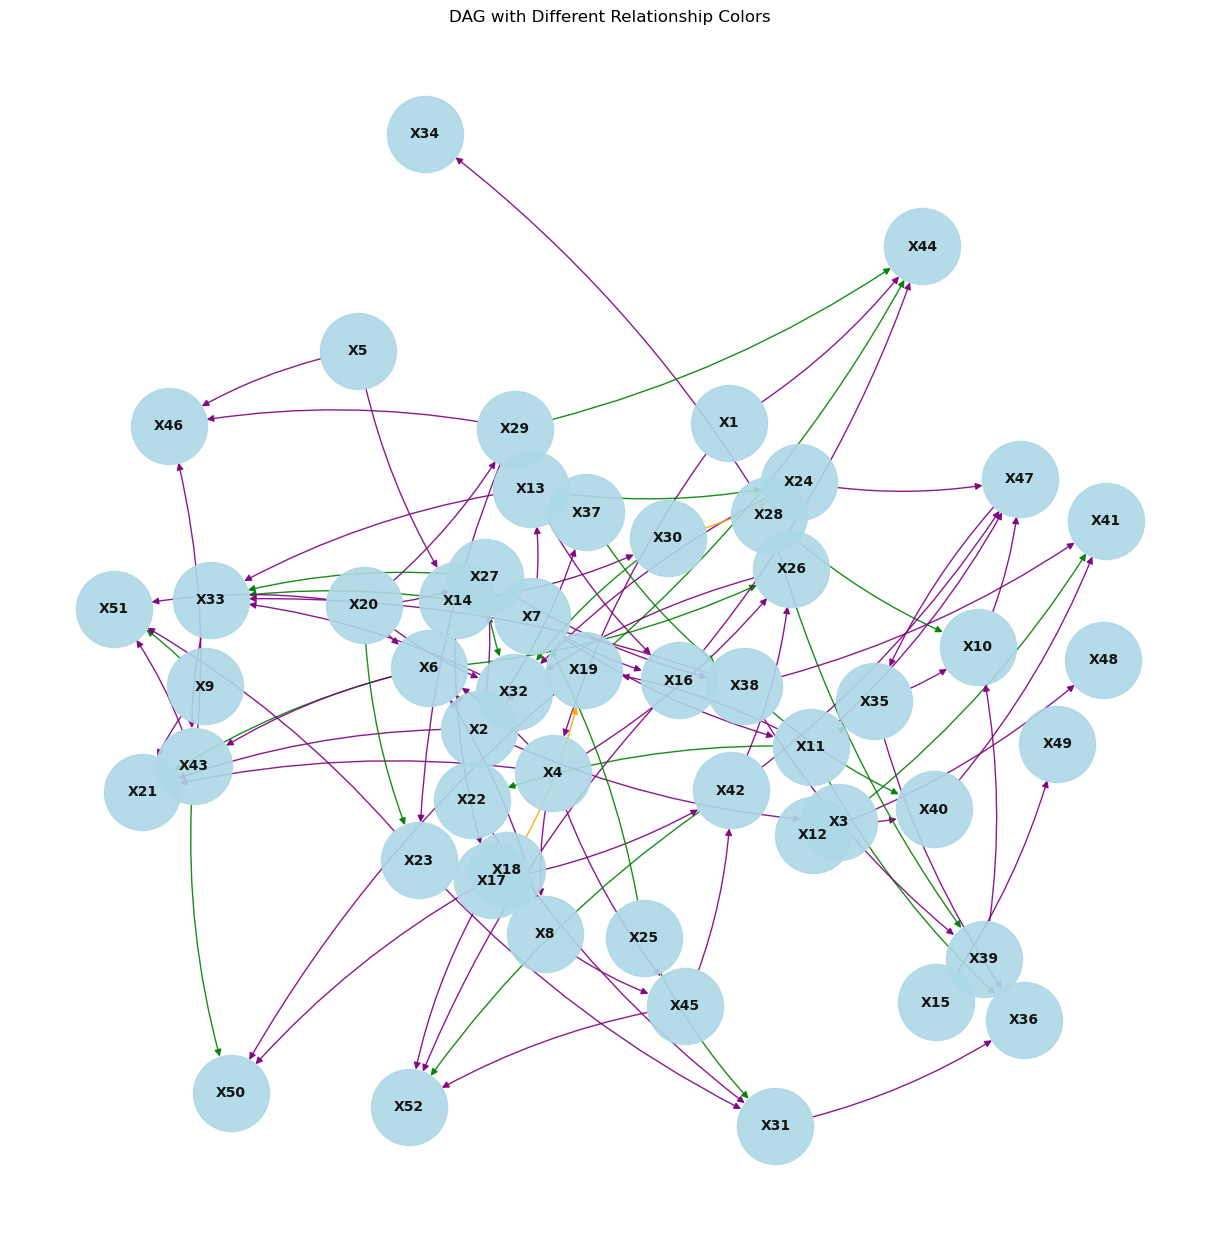

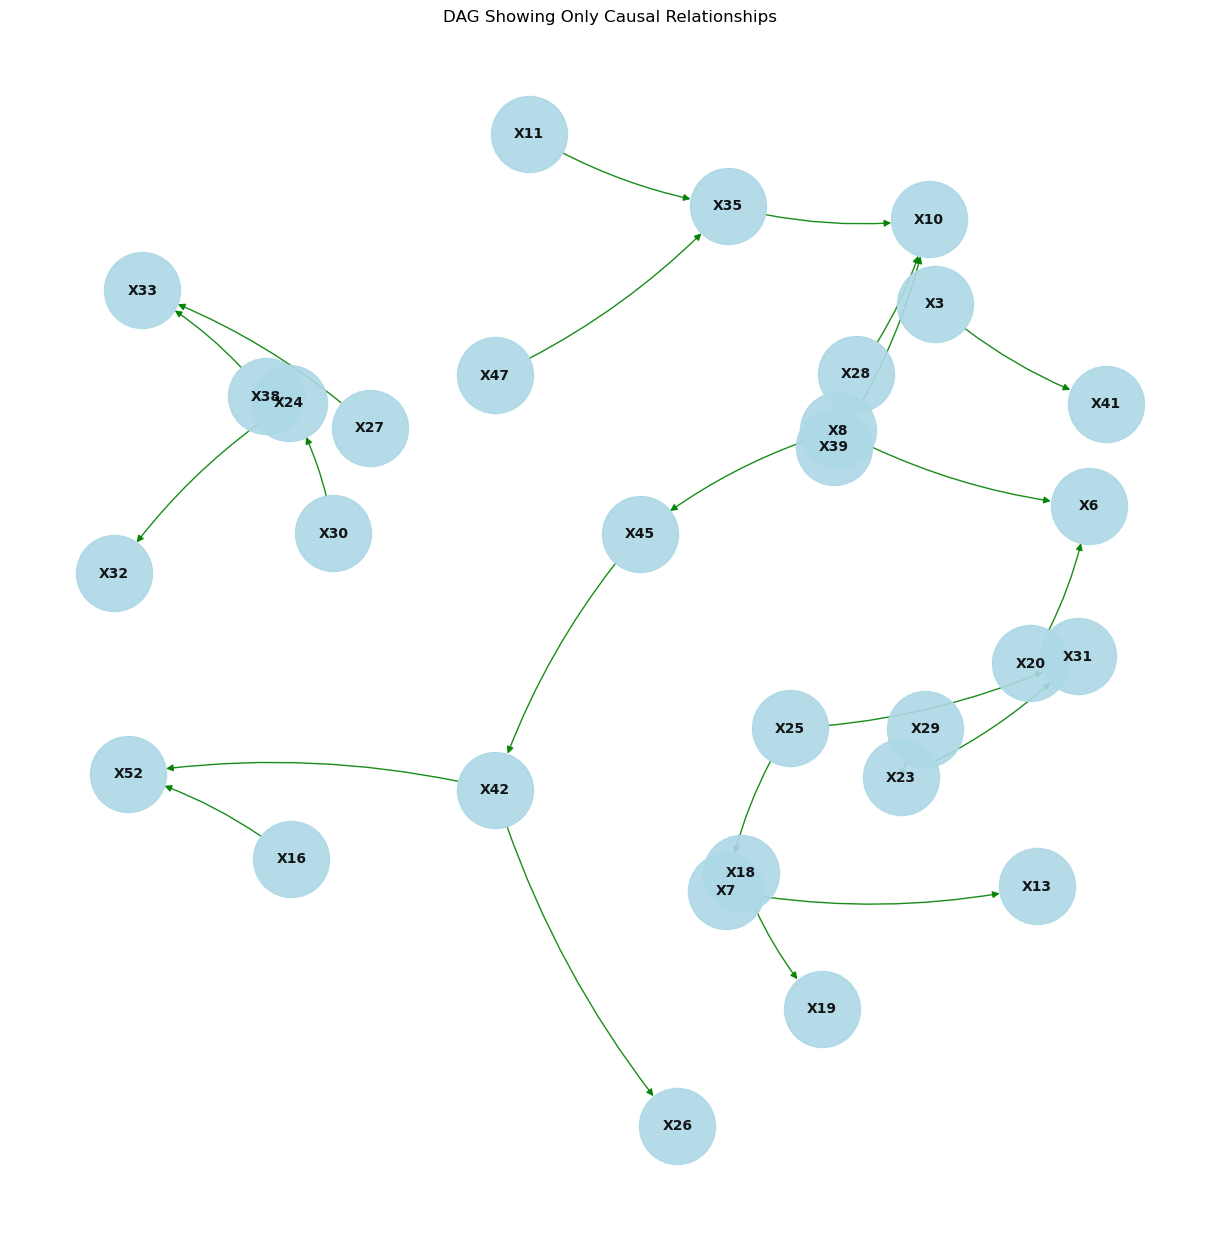

In [45]:
base_path = 'Documents/tennessee-eastmen-process-classification/TE_process/data/'
datasets = load_all_datasets(base_path)

combined_data = np.vstack([datasets[f'fault_{i:02d}'] for i in range(22)])
combined_data = standardize_data(combined_data)

print("Running FCI for combined variable data...")
G, edges = run_fci(combined_data)

if G is not None:
    print("\nFCI analysis completed.")

    print_causal_relationships(G)
    
    visualize_graph(G, title="DAG with Different Relationship Colors", show_weights=False)
    
    visualize_graph(G, title="DAG Showing Only Causal Relationships", causal_only=True, show_weights=False, hide_unconnected=True)
else:
    print("\nFCI analysis failed.")